In [28]:
InteractionsFileCaptureC='/srv/scratch/mtaranov/CaptureC_ChicagoCalls/CaptureC_SC_bait-bait.bed.gz'
#InteractionsFileHiC100='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/P-P_from_HiC/output/PP_SC_RE100.bed.gz'
#InteractionsFileHiC20='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/P-P_from_HiC/output/PP_SC_RE20.bed.gz'
#InteractionsFileHiC5='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/P-P_from_HiC/output/PP_SC_RE5.bed.gz'
PromoterFile='/srv/scratch/mtaranov/HindIII/PromoterCapture_Digest_Human_HindIII_baits_ID.bed'
PROJDIR='/users/mtaranov/NN_thres5max/'
DATAJDIR='/users/mtaranov/NN_thres5max/dist_matched/'

In [29]:
features_path='/srv/scratch/mtaranov/peaks_at_promoters/output_thres5_max/'
atac=features_path+'atac'
#TFs
ctcf=features_path+'CTCF'
pol3=features_path+'PolII'
TP63=features_path+'TP63'
LSD1=features_path+'LSD1'
#histone
H3K27ac=features_path+'H3K27ac'
H3K27me3=features_path+'H3K27me3'
H3K4me1=features_path+'H3K4me1'
H3K4me3=features_path+'H3K4me3'
H3K9ac=features_path+'H3K9ac'

In [30]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.stats.mstats import mquantiles
import scipy.stats as ss
import math
import scipy.linalg
import itertools
import copy
import random
import gzip
#reload(rcca)
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, roc_curve
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
import networkx as nx

In [31]:
def printMatrix(Matrix, ylabel, QuantileValue, LowerUpperLimit, title=''):
    #vmaxLim=mquantiles(Matrix,[0.99])[0]
    Lim=mquantiles(Matrix,[QuantileValue])[0]
    print Matrix.max()
    print np.shape(Matrix)
    print "Limit:", Lim
    fig, ax = plt.subplots()
    fig.subplots_adjust(top=0.8)
    if LowerUpperLimit == 'lower':
        m = ax.matshow(Matrix, origin="bottom", #norm=colors.LogNorm(),  #norm=colors.SymLogNorm(1),
               cmap="RdYlBu_r", vmin=Lim)
    else:
        m = ax.matshow(Matrix, origin="bottom", #norm=colors.LogNorm(),  #norm=colors.SymLogNorm(1),
               cmap="RdYlBu_r", vmax=Lim) # cmap="RdYlBu_r"


    ax.axhline(-0.5, color="#000000", linewidth=1, linestyle="--")
    ax.axvline(-0.5, color="#000000", linewidth=1, linestyle="--")

    cb = fig.colorbar(m)
    cb.set_label(ylabel)

    ax.set_ylim((-0.5, len(Matrix) - 0.5))
    ax.set_xlim((-0.5, len(Matrix) - 0.5))
    
    plt.title(title)
    plt.show()
    return


In [32]:
def set_diag_to_value(matrix, value):
    np.fill_diagonal(matrix, value)
    return matrix

In [33]:
def binarize(matrix, thres=0):
    matrix2=copy.copy(matrix)
    matrix2[matrix == thres] = 0
    matrix2[matrix > thres] = 1    
    return matrix2

In [34]:
def binarize_w_unlabeled(matrix, thres):
    matrix2=copy.copy(matrix)
    matrix2[matrix == 0] = 0
    matrix2[matrix > thres] = 1 
    matrix2[np.logical_and(matrix>0, matrix<=thres)] = -1
    return matrix2

In [35]:
def demean(d): return d-d.mean(0) 
def zscore(d): return (d-d.mean(0))/d.std(0)

In [36]:
#test proportion is computed as total-train
def shuffle_nodes (vector_1d, trainProportion, valiProportion):
    total_num=len(vector_1d)
    train_num=int(trainProportion*total_num)
    vali_num=int(valiProportion*total_num)
    test_num=total_num-train_num-vali_num
    if test_num<=0:
        print "Nothing in the test set!!!"
    print "Training set: "+str(train_num)
    print "Validation set: "+str(vali_num)
    print "Test set: "+str(test_num)
    #decide the random split of nodes
    nodes=[i for i in range(len(vector_1d))]
    shuffled_nodes=copy.copy(nodes)
    random.shuffle(shuffled_nodes)
    train_nodes=np.array(shuffled_nodes[:train_num])
    vali_nodes=np.array(shuffled_nodes[train_num:train_num+vali_num])
    test_nodes=np.array(shuffled_nodes[train_num+vali_num:])
    return train_nodes, vali_nodes, test_nodes
# shuffle and split nodes 
def train_vali_test(data_3d, labels_1d, trainProportion, valiProportion):
    train_nodes, vali_nodes, test_nodes = shuffle_nodes(labels_1d, trainProportion, valiProportion)
    train_set=data_3d[train_nodes, :, :]
    vali_set=data_3d[vali_nodes, :, :]
    test_set=data_3d[test_nodes, :, :]
    labels_train=labels_1d[train_nodes]
    labels_vali=labels_1d[vali_nodes]
    labels_test=labels_1d[test_nodes]
    #train_by_train=PPMatrix[shuffled_nodes[0]][:,shuffled_nodes[0]]
    #print "Train by train:", np.shape(train_by_train), "Test by train:", np.shape(test_by_train), "Test by test:", np.shape(test_by_test), "All by train:", np.shape(all_by_train), "All by all:", np.shape(all_by_all) 
    return train_set, vali_set, test_set, labels_train, labels_vali, labels_test

In [37]:
def build_distance_for_node(PromoterFile): 
    REFrag_dict={}
    # Assign indices to all promoter HindIII sites.
    for line in open(PromoterFile,'r'):
        words=line.rstrip().split()
        chr = words[0]
        hind3 = (words[1], words[2])
        if chr not in REFrag_dict:
            index=0
            REFrag_dict[chr]={hind3:index}
        else:
            index+=1
        REFrag_dict[chr].update({hind3:index})

    REsiteMids={}
    for chr in REFrag_dict:
        REsiteMids[chr] = np.zeros((len(REFrag_dict[chr]),1))
        for key in REFrag_dict[chr]:
            start = int(key[0])
            end = int(key[1])
            REsiteMids[chr][REFrag_dict[chr][key]] = (start + end)/2
        
    return REsiteMids

In [81]:
# builds adjacency matrix
def BuildMatrix(PromoterFile, InteractionsFile):

    REFrag_dict={}
    # Assign indices to all promoter HindIII sites.
    for line in open(PromoterFile,'r'):
        words=line.rstrip().split()
        chr = words[0]
        hind3 = (words[1], words[2])
        if chr not in REFrag_dict:
            index=0
            REFrag_dict[chr]={hind3:index}
        else:
            index+=1
        REFrag_dict[chr].update({hind3:index})
        
    labels_score={}
    for chr in REFrag_dict:
        uniq=0.0
        non_uniq=0.0
        # Initialize matrix (promoter x promoter)
        labels_score[chr] = np.ones((len(REFrag_dict[chr]), len(REFrag_dict[chr]))) #  number of promoters in chr 
        labels_score[chr] = labels_score[chr]*(-1)
 
    total_lines=0.0
    for line in gzip.open(InteractionsFile,'r'):
        words=line.rstrip().split()
        chr = words[0]
        hind3_1 = (words[1], words[2])
        hind3_2 = (words[4], words[5])
        q_values = float(words[6])

        i=REFrag_dict[chr][hind3_1]
        j=REFrag_dict[chr][hind3_2]
        
        if labels_score[chr][i,j] != -1:
            non_uniq+=1
            # mean
            labels_score[chr][i,j]=labels_score[chr][i,j]/2+q_values/2
            labels_score[chr][j,i]=labels_score[chr][j,i]/2+q_values/2
#             # max
#             labels_score[chr][i,j]=max(labels_score[chr][i,j], q_values)
#             labels_score[chr][j,i]=max(labels_score[chr][j,i], q_values)
        else:
            uniq +=1
            labels_score[chr][i,j]=q_values
            labels_score[chr][j,i]=q_values
            
        total_lines += 1
    
    print "non-unique entries in CaptureC file(bait1-bait2/bait2-bait1): ", non_uniq, " ", non_uniq/total_lines, "%"
    print "unique entries in CaptureC file(bait1-bait2/bait2-bait1): ", uniq, " ", uniq/total_lines, "%"
    return labels_score

In [39]:
# builds feature vector 
def get_features(PromoterFile, FeatureVectorFile, dataName):

    REFrag_dict={}
    # Assign indices to all promoter HindIII sites.
    for line in open(PromoterFile,'r'):
        words=line.rstrip().split()
        chr = words[0]
        hind3 = (words[1], words[2])
        if chr not in REFrag_dict:
            index=0
            REFrag_dict[chr]={hind3:index}
        else:
            index+=1
        REFrag_dict[chr].update({hind3:index})

    # Initialize vector (promoters only)
    vector=np.zeros((len(REFrag_dict),)) #  number of promoters in chr 1

    features={}
    for line in open(FeatureVectorFile,'r'):              
        words=line.rstrip().split()
        chr = words[0]
        hind3 = (words[1], words[2])
        value = words[3]
        if chr not in features:
            # Initialize vector (promoters only)
            features[chr] = np.zeros((len(REFrag_dict[chr]))) #  number of promoters in chr 
            features[chr][REFrag_dict[chr][hind3]] = value
        else:
            features[chr][REFrag_dict[chr][hind3]] = value
            

    # list of non-zero q-values
    nonzero_values=filter(lambda a: a != 0, np.array(features['chr1']).reshape(-1,).tolist()) 

    # Print out average q-values:
    print "Average value with zeros: ", str(np.average(features['chr1']))
    print "Average q-value w/o zeros: ", np.mean(nonzero_values)

    # Print distribution of q-values
    plt.hist(features['chr1'])
    plt.title(str(dataName))
    plt.show()

    return features

In [40]:
def get_data_labels(FeatureVector, labels_score):
    data={}
    labels={}
    for chr in FeatureVector:
        k=0
        data[chr]=np.zeros(((FeatureVector[chr].shape[0]**2-FeatureVector[chr].shape[0])/2,11,2))
        labels[chr]=np.zeros(((FeatureVector[chr].shape[0]**2-FeatureVector[chr].shape[0])/2,1))
        for i in range(FeatureVector[chr].shape[0]):
            for j in range(FeatureVector[chr].shape[0]):
                if i < j:
                    data[chr][k,:,0]=FeatureVector[chr][i,:]
                    data[chr][k,:,1]=FeatureVector[chr][j,:]
                    labels[chr][k]=labels_score[chr][i][j]
                    k+=1
    return data, labels

In [41]:
def remove_unlabeled(data, labels):
    indx_unlabeled = np.where(labels==-1)[0]
    new_labels=np.delete(labels, indx_unlabeled, 0)
    new_data=np.delete(data, indx_unlabeled, 0)
    return new_data, new_labels

In [42]:
def concatenate_chrs(data, labels):
    data_to_concatenate = []
    labels_to_concatenate = []
    for chr in data:
        data_to_concatenate.append(data[chr])
        labels_to_concatenate.append(labels[chr])
    return np.concatenate(data_to_concatenate, axis=0), np.concatenate(labels_to_concatenate, axis=0)

In [43]:
def get_pairs_distance_matched(X, y, min_dist, max_dist, dist_step, imbalance_ratio):
    
    def subsample_indx(indecies, size, imbalance_ratio):
        indecies_shuffled=copy.copy(indecies)
        np.random.shuffle(indecies_shuffled)
        num_subsampled = size*imbalance_ratio
        if num_subsampled > len(indecies[0]):
            print '    Error: Not enough to subsample'
            exit 
        #print indecies_shuffled[0].shape
        #print indecies_shuffled[0][:num_subsampled].shape
        else:
            return indecies_shuffled[0][:num_subsampled]

    neg_indxs = np.where(y==0)[0]
    pos_indxs = np.where(y==1)[0]
    X_pos=X[pos_indxs]
    X_neg=X[neg_indxs]
    y_pos=y[pos_indxs]
    y_neg=y[neg_indxs]
    
    #indx_pos=indx[pos_indxs]
    #indx_neg=indx[neg_indxs]
    
    thres1=min_dist+dist_step
    thres2=min_dist
    
    X_new=np.empty(([0,X.shape[1],X.shape[2]]))
    y_new=np.empty(([0,y.shape[1]]))
    #indx_new=np.empty(([0]))
    
    while thres1 <= max_dist:
        print 'distance window: ', '[', thres2, ',', thres1, ']'
        neg_indx_at_dist=np.where((abs(X_neg[:, 10, 0] - X_neg[:, 10, 1]) <= thres1) & (abs(X_neg[:, 10, 0] - X_neg[:, 10, 1]) >= thres2))
        pos_indx_at_dist=np.where((abs(X_pos[:, 10, 0] - X_pos[:, 10, 1]) <= thres1) & (abs(X_pos[:, 10, 0] - X_pos[:, 10, 1]) >= thres2))

        if len(pos_indx_at_dist[0])> len(neg_indx_at_dist[0]):
            #print 'more pos than neg'
            print 'number of pos at distance=:',  len(pos_indx_at_dist[0])
            print 'number of neg at distance=:',  len(neg_indx_at_dist[0])
            indx_subsampled=subsample_indx(pos_indx_at_dist, len(neg_indx_at_dist[0]), imbalance_ratio)
            new_pos_indx_at_dist=indx_subsampled 
            new_neg_indx_at_dist=neg_indx_at_dist[0]

        else:
            #print 'more neg than pos'
            print 'number of pos at distance=',  len(pos_indx_at_dist[0])
            print 'number of neg at distance=',  len(neg_indx_at_dist[0])
            indx_subsampled=subsample_indx(neg_indx_at_dist, len(pos_indx_at_dist[0]), imbalance_ratio)
            new_pos_indx_at_dist=pos_indx_at_dist[0]
            new_neg_indx_at_dist=indx_subsampled
         
        y_pos_at_dist=y_pos[new_pos_indx_at_dist]
        y_neg_at_dist=y_neg[new_neg_indx_at_dist]
        X_pos_at_dist=X_pos[new_pos_indx_at_dist]
        X_neg_at_dist=X_neg[new_neg_indx_at_dist]

        y_at_dist=np.concatenate((y_pos_at_dist, y_neg_at_dist))
        X_at_dist=np.concatenate((X_pos_at_dist, X_neg_at_dist))
        
        #indx_at_dist=np.concatenate((new_pos_indx_at_dist, new_neg_indx_at_dist))
        print 'labels at dist: ', y_at_dist.shape
        print 'data at dist: ', X_at_dist.shape 
        #print 'indx at dist: ', indx_at_dist.shape

        #indx_new=np.concatenate((indx_new, indx_at_dist))
        X_new=np.concatenate((X_new, X_at_dist))
        y_new=np.concatenate((y_new, y_at_dist))
        
        
        #print X_new.shape, X_at_dist.shape
        #print y_new.shape, y_at_dist.shape
        #print indx_new.shape, indx_at_dist.shape
        
        #print "# of neg:", np.where(y_at_dist==0)[0].shape
        #print "# of pos:", np.where(y_at_dist==1)[0].shape
        
        #thres2=thres1+min_dist
        thres2=thres1
        thres1=thres1+dist_step
              
    return X_new, y_new
#indx_new

In [44]:
 def impose_dist_constrains(data, labels, min_dist, max_dist):
    indx_unlabeled = np.where((abs(data[:, 10, 0] - data[:, 10, 1]) <= max_dist) & (abs(data[:, 10, 0] - data[:, 10, 1]) >= min_dist))
    new_labels=labels[indx_unlabeled]
    new_data=data[indx_unlabeled]
    return new_data, new_labels

# def impose_dist_constrains(data, labels, min_dist, max_dist):
#     indx1_unlabeled = np.where(abs(data[:,10,1] - data[:,10,0]) > max_dist)[0]
#     new_labels=np.delete(labels, indx1_unlabeled, 0)
#     new_data=np.delete(data, indx1_unlabeled, 0)
#     indx2_unlabeled = np.where(abs(new_data[:,10,1] - new_data[:,10,0]) < min_dist)[0]
#     new2_labels=np.delete(new_labels, indx2_unlabeled, 0)
#     new2_data=np.delete(new_data, indx2_unlabeled, 0)
#     return new2_data, new2_labels

In [45]:
labels_score = BuildMatrix(PromoterFile, InteractionsFileCaptureC)

non-unique entries in CaptureC file(bait1-bait2/bait2-bait1):  1237741.0   0.49244938606 %
unique entries in CaptureC file(bait1-bait2/bait2-bait1):  1275697.0   0.50755061394 %


In [46]:
sum=0
for chr in labels_score:
    sum=sum+labels_score[chr][np.where(labels_score[chr] >=0)].shape[0]
print "number of labels>=0:", sum/2

number of labels>=0: 1275697


In [47]:
sum=0
for chr in labels_score:
    sum=sum+labels_score[chr][np.where(labels_score[chr] >=5)].shape[0]
print "number of labels>=5:", sum/2

number of labels>=5: 16481


92.491795676
(2272, 2272)
Limit: 92.491795676


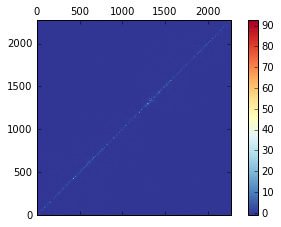

In [48]:
printMatrix(labels_score['chr1'], '', 1, 1, title='')

51.0563147144
(300, 300)
Limit: 51.0563147144


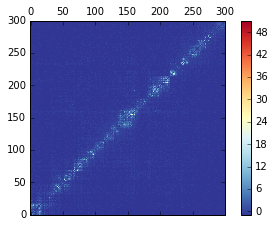

In [49]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(subset, '', 1, i, title='')

1.0
(300, 300)
Limit: 1.0


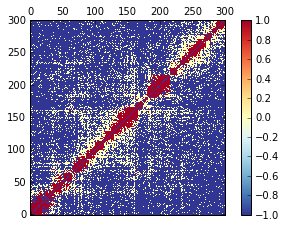

In [50]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(binarize(subset), '', 1, i, title='')

1.0
(300, 300)
Limit: 1.0


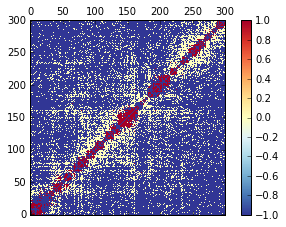

In [51]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(binarize_w_unlabeled(subset, 1), '', 1, i, title='')

1.0
(300, 300)
Limit: 1.0


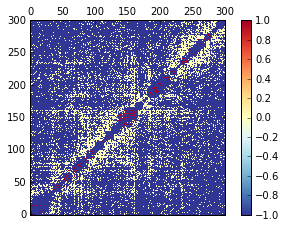

In [52]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(binarize_w_unlabeled(subset, 5), '', 1, i, title='')

Average value with zeros:  21.9245984551
Average q-value w/o zeros:  33.3418257631


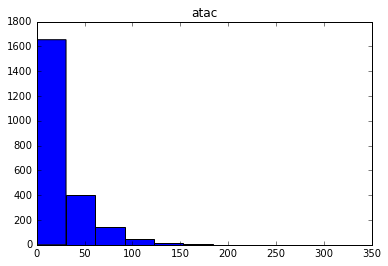

Average value with zeros:  30.8321433979
Average q-value w/o zeros:  63.798387796


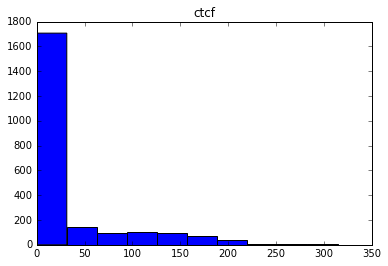

Average value with zeros:  18.2601188732
Average q-value w/o zeros:  35.2780527891


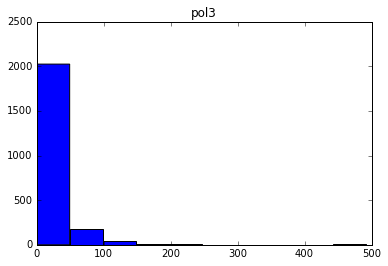

Average value with zeros:  6.97454184859
Average q-value w/o zeros:  17.6657291862


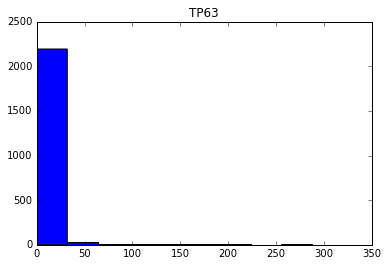

Average value with zeros:  0.828355180458
Average q-value w/o zeros:  9.04818735577


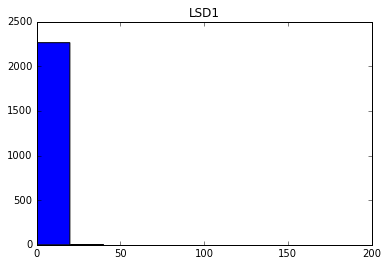

Average value with zeros:  29.1659232835
Average q-value w/o zeros:  55.7316885618


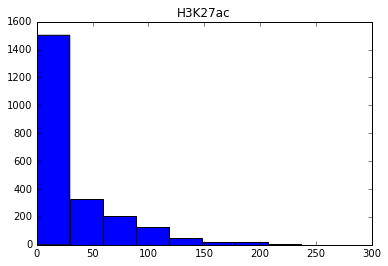

Average value with zeros:  3.3275984419
Average q-value w/o zeros:  16.0175925


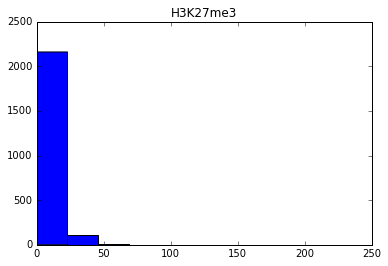

Average value with zeros:  10.5938546083
Average q-value w/o zeros:  15.7418166579


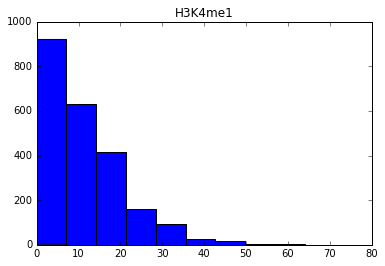

Average value with zeros:  105.891611549
Average q-value w/o zeros:  179.809971181


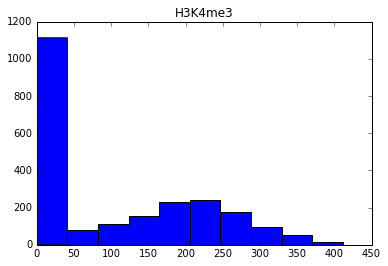

Average value with zeros:  16.4996693574
Average q-value w/o zeros:  30.6268372386


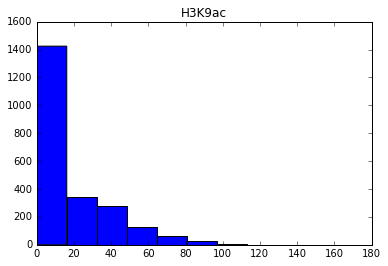

In [53]:
VectorATAC=get_features(PromoterFile, atac, 'atac')

VectorCTCF=get_features(PromoterFile, ctcf, 'ctcf')
VectorPOL3=get_features(PromoterFile, pol3, 'pol3')
VectorTP63=get_features(PromoterFile, TP63, 'TP63')
VectorLSD1=get_features(PromoterFile, LSD1, 'LSD1')

VectorH3K27ac=get_features(PromoterFile, H3K27ac, 'H3K27ac')
VectorH3K27me3=get_features(PromoterFile, H3K27me3, 'H3K27me3')
VectorH3K4me1=get_features(PromoterFile, H3K4me1, 'H3K4me1')
VectorH3K4me3=get_features(PromoterFile, H3K4me3, 'H3K4me3')
VectorH3K9ac=get_features(PromoterFile, H3K9ac, 'H3K9ac')

In [54]:
distance_for_node = build_distance_for_node(PromoterFile)

In [55]:
FeatureVector_wo_dist = {}
FeatureVector = {}
for chr in VectorATAC:
    if chr != 'chrY':
        FeatureVector_wo_dist[chr] = demean(np.vstack((VectorATAC[chr], VectorCTCF[chr], VectorPOL3[chr], VectorTP63[chr], VectorLSD1[chr], VectorH3K27ac[chr], VectorH3K27me3[chr], VectorH3K4me1[chr], VectorH3K4me3[chr], VectorH3K9ac[chr])).T)
        FeatureVector[chr] = np.concatenate((FeatureVector_wo_dist[chr], distance_for_node[chr]), axis=1)
#FeatureVectorDistance = demean(np.vstack((VectorATAC, VectorCTCF, VectorPOL3, VectorTP63, VectorLSD1, VectorH3K27ac, VectorH3K27me3, VectorH3K4me1, VectorH3K4me3, VectorH3K9ac, distance_for_node)).T)

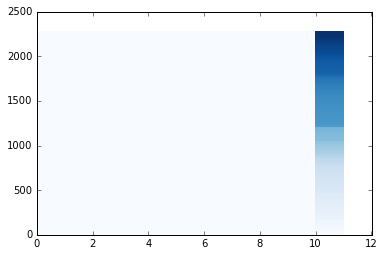

In [56]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(FeatureVector['chr1'], cmap=plt.cm.Blues)
#heatmap = ax.pcolor(DistanceFeatureVectorK, cmap=plt.cm.Blues)

In [57]:
data, labels  = get_data_labels(FeatureVector, labels_score)

In [58]:
data_all_chrs, labels_all_chrs = concatenate_chrs(data, labels)

In [59]:
labels_all_chrs[np.where(labels_all_chrs >=5)].shape

(16477,)

In [60]:
data_all_chrs_gt10kb_lt2Mb, labels_all_chrs_gt10kb_lt2Mb = impose_dist_constrains(data_all_chrs, labels_all_chrs, 10000, 2000000)

In [61]:
data_all_chrs_gt10kb_lt2Mb.shape

(496467, 11, 2)

In [62]:
# data_all_wo_unlbd_at_0, labels_all_wo_unlbd_at_0 = remove_unlabeled(data_all_chrs_gt10kb_lt2Mb, binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 0))
# data_all_wo_unlbd_at_3, labels_all_wo_unlbd_at_3 = remove_unlabeled(data_all_chrs_gt10kb_lt2Mb, binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 3))
# data_all_wo_unlbd_at_5, labels_all_wo_unlbd_at_5 = remove_unlabeled(data_all_chrs_gt10kb_lt2Mb, binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 5))

In [63]:
data_all_wo_unlbd_at_0, labels_all_wo_unlbd_at_0 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 0))
data_all_wo_unlbd_at_3, labels_all_wo_unlbd_at_3 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 3))
data_all_wo_unlbd_at_5, labels_all_wo_unlbd_at_5 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 5))
data_all_wo_unlbd_at_7, labels_all_wo_unlbd_at_7 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 7))
data_all_wo_unlbd_at_10, labels_all_wo_unlbd_at_10 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 10))

In [64]:
train_set_thres_0, vali_set_thres_0, test_set_thres_0, labels_train_thres_0, labels_vali_thres_0, labels_test_thres_0 =train_vali_test(data_all_wo_unlbd_at_0, labels_all_wo_unlbd_at_0, 0.5, 0.3)

Training set: 637812
Validation set: 382687
Test set: 255126


In [65]:
train_set_thres_3, vali_set_thres_3, test_set_thres_3, labels_train_thres_3, labels_vali_thres_3, labels_test_thres_3 =train_vali_test(data_all_wo_unlbd_at_3, labels_all_wo_unlbd_at_3, 0.5, 0.3)

Training set: 566126
Validation set: 339675
Test set: 226451


In [66]:
train_set_thres_5, vali_set_thres_5, test_set_thres_5, labels_train_thres_5, labels_vali_thres_5, labels_test_thres_5 =train_vali_test(data_all_wo_unlbd_at_5, labels_all_wo_unlbd_at_5, 0.5, 0.3)

Training set: 556618
Validation set: 333971
Test set: 222648


In [67]:
train_set_thres_7, vali_set_thres_7, test_set_thres_7, labels_train_thres_7, labels_vali_thres_7, labels_test_thres_7 =train_vali_test(data_all_wo_unlbd_at_7, labels_all_wo_unlbd_at_7, 0.5, 0.3)

Training set: 552822
Validation set: 331693
Test set: 221129


In [68]:
train_set_thres_10, vali_set_thres_10, test_set_thres_10, labels_train_thres_10, labels_vali_thres_10, labels_test_thres_10 =train_vali_test(data_all_wo_unlbd_at_10, labels_all_wo_unlbd_at_10, 0.5, 0.3)

Training set: 550473
Validation set: 330284
Test set: 220190


In [69]:
min_dist=10000
max_dist=2000000
dist_step=10000
class_imbalance=1
X_test_distance_matched_at_0, y_test_distance_matched_at_0 = get_pairs_distance_matched(test_set_thres_0, labels_test_thres_0, min_dist, max_dist, dist_step, class_imbalance)
X_train_distance_matched_at_0, y_train_distance_matched_at_0 = get_pairs_distance_matched(train_set_thres_0, labels_train_thres_0, min_dist, max_dist, dist_step, class_imbalance)
X_valid_distance_matched_at_0, y_valid_distance_matched_at_0 = get_pairs_distance_matched(vali_set_thres_0, labels_vali_thres_0, min_dist, max_dist, dist_step, class_imbalance)

distance window:  [ 10000 , 20000 ]
number of pos at distance=: 527
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 20000 , 30000 ]
number of pos at distance=: 656
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 30000 , 40000 ]
number of pos at distance=: 585
number of neg at distance=: 1
labels at dist:  (2, 1)
data at dist:  (2, 11, 2)
distance window:  [ 40000 , 50000 ]
number of pos at distance=: 668
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 50000 , 60000 ]
number of pos at distance=: 645
number of neg at distance=: 1
labels at dist:  (2, 1)
data at dist:  (2, 11, 2)
distance window:  [ 60000 , 70000 ]
number of pos at distance=: 635
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 70000 , 80000 ]
number of pos at distance=: 693
number of neg at distance=: 2
labels at dist

In [70]:
min_dist=10000
max_dist=2000000
dist_step=10000
class_imbalance=1
X_test_distance_matched_at_3, y_test_distance_matched_at_3 = get_pairs_distance_matched(test_set_thres_3, labels_test_thres_3, min_dist, max_dist, dist_step, class_imbalance)
X_train_distance_matched_at_3, y_train_distance_matched_at_3 = get_pairs_distance_matched(train_set_thres_3, labels_train_thres_3, min_dist, max_dist, dist_step, class_imbalance)
X_valid_distance_matched_at_3, y_valid_distance_matched_at_3 = get_pairs_distance_matched(vali_set_thres_3, labels_vali_thres_3, min_dist, max_dist, dist_step, class_imbalance)

distance window:  [ 10000 , 20000 ]
number of pos at distance=: 203
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 20000 , 30000 ]
number of pos at distance=: 205
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 30000 , 40000 ]
number of pos at distance=: 155
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 40000 , 50000 ]
number of pos at distance=: 161
number of neg at distance=: 1
labels at dist:  (2, 1)
data at dist:  (2, 11, 2)
distance window:  [ 50000 , 60000 ]
number of pos at distance=: 166
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 60000 , 70000 ]
number of pos at distance=: 143
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 70000 , 80000 ]
number of pos at distance=: 169
number of neg at distance=: 1
labels at dist

In [71]:
min_dist=10000
max_dist=2000000
dist_step=10000
class_imbalance=1
X_test_distance_matched_at_5, y_test_distance_matched_at_5 = get_pairs_distance_matched(test_set_thres_5, labels_test_thres_5, min_dist, max_dist, dist_step, class_imbalance)
X_train_distance_matched_at_5, y_train_distance_matched_at_5 = get_pairs_distance_matched(train_set_thres_5, labels_train_thres_5, min_dist, max_dist, dist_step, class_imbalance)
X_valid_distance_matched_at_5, y_valid_distance_matched_at_5 = get_pairs_distance_matched(vali_set_thres_5, labels_vali_thres_5, min_dist, max_dist, dist_step, class_imbalance)

distance window:  [ 10000 , 20000 ]
number of pos at distance=: 112
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 20000 , 30000 ]
number of pos at distance=: 95
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 30000 , 40000 ]
number of pos at distance=: 79
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 40000 , 50000 ]
number of pos at distance=: 79
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 50000 , 60000 ]
number of pos at distance=: 69
number of neg at distance=: 1
labels at dist:  (2, 1)
data at dist:  (2, 11, 2)
distance window:  [ 60000 , 70000 ]
number of pos at distance=: 63
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 70000 , 80000 ]
number of pos at distance=: 99
number of neg at distance=: 1
labels at dist:  (2,

In [72]:
min_dist=10000
max_dist=2000000
dist_step=10000
class_imbalance=1
X_test_distance_matched_at_7, y_test_distance_matched_at_7 = get_pairs_distance_matched(test_set_thres_7, labels_test_thres_7, min_dist, max_dist, dist_step, class_imbalance)
X_train_distance_matched_at_7, y_train_distance_matched_at_7 = get_pairs_distance_matched(train_set_thres_7, labels_train_thres_7, min_dist, max_dist, dist_step, class_imbalance)
X_valid_distance_matched_at_7, y_valid_distance_matched_at_7 = get_pairs_distance_matched(vali_set_thres_7, labels_vali_thres_7, min_dist, max_dist, dist_step, class_imbalance)

distance window:  [ 10000 , 20000 ]
number of pos at distance=: 66
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 20000 , 30000 ]
number of pos at distance=: 69
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 30000 , 40000 ]
number of pos at distance=: 57
number of neg at distance=: 2
labels at dist:  (4, 1)
data at dist:  (4, 11, 2)
distance window:  [ 40000 , 50000 ]
number of pos at distance=: 50
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 50000 , 60000 ]
number of pos at distance=: 33
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 60000 , 70000 ]
number of pos at distance=: 36
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 70000 , 80000 ]
number of pos at distance=: 58
number of neg at distance=: 1
labels at dist:  (2, 

In [73]:
min_dist=10000
max_dist=2000000
dist_step=10000
class_imbalance=1
X_test_distance_matched_at_10, y_test_distance_matched_at_10 = get_pairs_distance_matched(test_set_thres_10, labels_test_thres_10, min_dist, max_dist, dist_step, class_imbalance)
X_train_distance_matched_at_10, y_train_distance_matched_at_10 = get_pairs_distance_matched(train_set_thres_10, labels_train_thres_10, min_dist, max_dist, dist_step, class_imbalance)
X_valid_distance_matched_at_10, y_valid_distance_matched_at_10 = get_pairs_distance_matched(vali_set_thres_10, labels_vali_thres_10, min_dist, max_dist, dist_step, class_imbalance)

distance window:  [ 10000 , 20000 ]
number of pos at distance=: 34
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 20000 , 30000 ]
number of pos at distance=: 26
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 30000 , 40000 ]
number of pos at distance=: 13
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 40000 , 50000 ]
number of pos at distance=: 22
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 50000 , 60000 ]
number of pos at distance=: 25
number of neg at distance=: 1
labels at dist:  (2, 1)
data at dist:  (2, 11, 2)
distance window:  [ 60000 , 70000 ]
number of pos at distance=: 25
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
distance window:  [ 70000 , 80000 ]
number of pos at distance=: 24
number of neg at distance=: 2
labels at dist:  (4, 

In [74]:
print "in all chrs:"
y_at_0=np.concatenate((y_train_distance_matched_at_0, y_valid_distance_matched_at_0, y_test_distance_matched_at_0), axis=0)
print "pos at thres=0: ", np.where(y_at_0 > 0)[0].shape[0]
print "neg at thres=0: ", np.where(y_at_0 == 0)[0].shape[0]
print "total: ", y_at_0.shape[0]

in all chrs:
pos at thres=0:  56507
neg at thres=0:  56507
total:  113014


In [75]:
print "in all chrs:"
y_at_3=np.concatenate((y_train_distance_matched_at_3, y_valid_distance_matched_at_3, y_test_distance_matched_at_3), axis=0)
print "pos at thres=0: ", np.where(y_at_3 > 0)[0].shape[0]
print "neg at thres=0: ", np.where(y_at_3 == 0)[0].shape[0]
print "total: ", y_at_3.shape[0]

in all chrs:
pos at thres=0:  13977
neg at thres=0:  13977
total:  27954


In [76]:
print "in all chrs:"
y_at_5=np.concatenate((y_train_distance_matched_at_5, y_valid_distance_matched_at_5, y_test_distance_matched_at_5), axis=0)
print "pos at thres=0: ", np.where(y_at_5 > 0)[0].shape[0]
print "neg at thres=0: ", np.where(y_at_5 == 0)[0].shape[0]
print "total: ", y_at_5.shape[0]

in all chrs:
pos at thres=0:  7393
neg at thres=0:  7393
total:  14786


In [77]:
print "in all chrs:"
y_at_7=np.concatenate((y_train_distance_matched_at_7, y_valid_distance_matched_at_7, y_test_distance_matched_at_7), axis=0)
print "pos at thres=0: ", np.where(y_at_7 > 0)[0].shape[0]
print "neg at thres=0: ", np.where(y_at_7 == 0)[0].shape[0]
print "total: ", y_at_7.shape[0]

in all chrs:
pos at thres=0:  4413
neg at thres=0:  4413
total:  8826


In [78]:
print "in all chrs:"
y_at_10=np.concatenate((y_train_distance_matched_at_10, y_valid_distance_matched_at_10, y_test_distance_matched_at_10), axis=0)
print "pos at thres=0: ", np.where(y_at_10 > 0)[0].shape[0]
print "neg at thres=0: ", np.where(y_at_10 == 0)[0].shape[0]
print "total: ", y_at_10.shape[0]

in all chrs:
pos at thres=0:  2291
neg at thres=0:  2291
total:  4582


In [80]:
np.save(DATAJDIR+'X_train_thres_10_maxij.npy', X_train_distance_matched_at_10) 
np.save(DATAJDIR+'X_valid_thres_10_maxij.npy', X_valid_distance_matched_at_10) 
np.save(DATAJDIR+'X_test_thres_10_maxij.npy', X_test_distance_matched_at_10) 
np.save(DATAJDIR+'y_train_thres_10_maxij.npy', y_train_distance_matched_at_10)
np.save(DATAJDIR+'y_valid_thres_10_maxij.npy', y_valid_distance_matched_at_10)
np.save(DATAJDIR+'y_test_thres_10_maxij.npy', y_test_distance_matched_at_10)

In [ ]:
# np.save(DATAJDIR+'X_train_thres_0.npy', X_train_distance_matched_at_0) 
# np.save(DATAJDIR+'X_valid_thres_0.npy', X_valid_distance_matched_at_0) 
# np.save(DATAJDIR+'X_test_thres_0.npy', X_test_distance_matched_at_0) 
# np.save(DATAJDIR+'y_train_thres_0.npy', y_train_distance_matched_at_0)
# np.save(DATAJDIR+'y_valid_thres_0.npy', y_valid_distance_matched_at_0)
# np.save(DATAJDIR+'y_test_thres_0.npy', y_test_distance_matched_at_0)

# np.save(DATAJDIR+'X_train_thres_3.npy', X_train_distance_matched_at_3) 
# np.save(DATAJDIR+'X_valid_thres_3.npy', X_valid_distance_matched_at_3) 
# np.save(DATAJDIR+'X_test_thres_3.npy', X_test_distance_matched_at_3) 
# np.save(DATAJDIR+'y_train_thres_3.npy', y_train_distance_matched_at_3)
# np.save(DATAJDIR+'y_valid_thres_3.npy', y_valid_distance_matched_at_3)
# np.save(DATAJDIR+'y_test_thres_3.npy', y_test_distance_matched_at_3)

# np.save(DATAJDIR+'X_train_thres_5.npy', X_train_distance_matched_at_5) 
# np.save(DATAJDIR+'X_valid_thres_5.npy', X_valid_distance_matched_at_5) 
# np.save(DATAJDIR+'X_test_thres_5.npy', X_test_distance_matched_at_5) 
# np.save(DATAJDIR+'y_train_thres_5.npy', y_train_distance_matched_at_5)
# np.save(DATAJDIR+'y_valid_thres_5.npy', y_valid_distance_matched_at_5)
# np.save(DATAJDIR+'y_test_thres_5.npy', y_test_distance_matched_at_5)

# np.save(DATAJDIR+'X_train_thres_7.npy', X_train_distance_matched_at_7) 
# np.save(DATAJDIR+'X_valid_thres_7.npy', X_valid_distance_matched_at_7) 
# np.save(DATAJDIR+'X_test_thres_7.npy', X_test_distance_matched_at_7) 
# np.save(DATAJDIR+'y_train_thres_7.npy', y_train_distance_matched_at_7)
# np.save(DATAJDIR+'y_valid_thres_7.npy', y_valid_distance_matched_at_7)
# np.save(DATAJDIR+'y_test_thres_7.npy', y_test_distance_matched_at_7)

# np.save(DATAJDIR+'X_train_thres_10.npy', X_train_distance_matched_at_10) 
# np.save(DATAJDIR+'X_valid_thres_10.npy', X_valid_distance_matched_at_10) 
# np.save(DATAJDIR+'X_test_thres_10.npy', X_test_distance_matched_at_10) 
# np.save(DATAJDIR+'y_train_thres_10.npy', y_train_distance_matched_at_10)
# np.save(DATAJDIR+'y_valid_thres_10.npy', y_valid_distance_matched_at_10)
# np.save(DATAJDIR+'y_test_thres_10.npy', y_test_distance_matched_at_10)
# #d = np.load('labels_test_all.npy')